#이번 강의의 내용 : 가우시안분포와 이상치분석 & 추천 시스템

In [ ]:
# libraries
#%matplotlib notebook

import pandas as pd
import numpy as np

import matplotlib
import seaborn
import matplotlib.dates as md
from matplotlib import pyplot as plt

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
#from pyemma import msm # not available on Kaggle Kernel
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

In [ ]:
df = pd.read_csv("ambient_temperature_system_failure.csv")
df

,timestamp,value
0,2013-07-04 00:00:00,69.880835
1,2013-07-04 01:00:00,71.220227
2,2013-07-04 02:00:00,70.877805
3,2013-07-04 03:00:00,68.959400
4,2013-07-04 04:00:00,69.283551
...,...,...
7262,2014-05-28 11:00:00,72.370206
7263,2014-05-28 12:00:00,72.172956
7264,2014-05-28 13:00:00,72.046565
7265,2014-05-28 14:00:00,71.825226


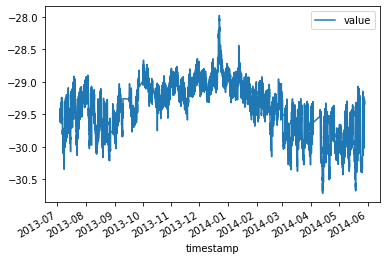

In [ ]:
# change the type of timestamp column for plotting
df['timestamp'] = pd.to_datetime(df['timestamp'])
# change fahrenheit to °C (temperature mean= 71 -> fahrenheit)
df['value'] = (df['value'] - 32) * 5/9
# plot the data
df.plot(x='timestamp', y='value')


#중간에 엄청 높은 값이 있다. 아마 저게 이상치일 것이다.

아하 시계열 데이터구나!

In [ ]:
#시계열 데이터를 나누어준다.
# change the type of timestamp column for plotting
df['timestamp'] = pd.to_datetime(df['timestamp'])
# 섭씨를 화씨로 바꾸어주는 작업이다. °C: 5/9(x − 32)
df['value'] = (df['value'] - 32) * 5/9
df['hours'] = df['timestamp'].dt.hour
#낮 시간은 오전 7시부터 오후 10시까지
df['daylight'] = ((df['hours'] >= 7) & (df['hours'] <= 22)).astype(int)
#낮이면 1 밤이면 0
print(df['daylight'])

0       0
1       0
2       0
3       0
4       0
       ..
7262    1
7263    1
7264    1
7265    1
7266    1
Name: daylight, Length: 7267, dtype: int64


In [ ]:
#주말
df['DayOfTheWeek'] = df['timestamp'].dt.dayofweek
#평일
df['WeekDay'] = (df['DayOfTheWeek'] < 5).astype(int)
# An estimation of anomly population of the dataset (necessary for several algorithm)
#강의에서 e뒤집어 놓은 것
outliers_fraction = 0.01
print(df['DayOfTheWeek'].value_counts())
print(df['WeekDay'].value_counts())
#대충 보니까 0~4일가지 평일이고
#1이 평일 같음.

4    1066
3    1064
1    1054
2    1048
5    1032
0    1011
6     992
Name: DayOfTheWeek, dtype: int64
1    5243
0    2024
Name: WeekDay, dtype: int64


In [ ]:
#이건 뭐한건지 잘 모르겠음.
df['time_epoch'] = (df['timestamp'].astype(np.int64)/100000000000).astype(np.int64)

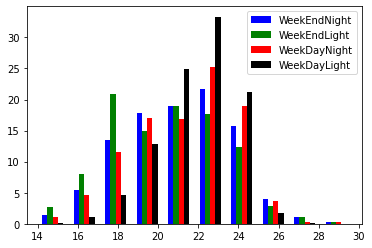

In [ ]:
# creation of 4 distinct categories that seem useful (week end/day week & night/day)
df['categories'] = df['WeekDay']*2 + df['daylight']
#주말 평일 / 밤 낮
a = df.loc[df['categories'] == 0, 'value'] # 0 + 0 # 주말 / 밤
b = df.loc[df['categories'] == 1, 'value'] # 0 + 1 # 주말 / 낮
c = df.loc[df['categories'] == 2, 'value'] # 2 + 0 # 평일 / 밤
d = df.loc[df['categories'] == 3, 'value'] # 2 + 1 # 평일 / 낮

fig, ax = plt.subplots()
a_heights, a_bins = np.histogram(a)
b_heights, b_bins = np.histogram(b, bins=a_bins)
c_heights, c_bins = np.histogram(c, bins=a_bins)
d_heights, d_bins = np.histogram(d, bins=a_bins)
#히스토그램의 높이와 막대를 설정해줌. 넘파이를 사용
width = (a_bins[1] - a_bins[0])/6

ax.bar(a_bins[:-1], a_heights*100/a.count(), width=width, facecolor='blue', label='WeekEndNight')
ax.bar(b_bins[:-1]+width, (b_heights*100/b.count()), width=width, facecolor='green', label ='WeekEndLight')
ax.bar(c_bins[:-1]+width*2, (c_heights*100/c.count()), width=width, facecolor='red', label ='WeekDayNight')
ax.bar(d_bins[:-1]+width*3, (d_heights*100/d.count()), width=width, facecolor='black', label ='WeekDayLight')

plt.legend()
plt.show()

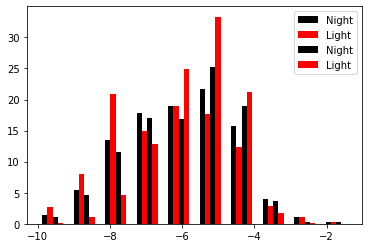

In [ ]:
#낮 밤만 보자.
# creation of 4 distinct categories that seem useful (week end/day week & night/day)
df['categories'] = df['WeekDay']*2 + df['daylight']
#주말 평일 / 밤 낮
a = df.loc[df['categories'] == 0, 'value'] # 0 + 0 # 주말 / 밤
b = df.loc[df['categories'] == 1, 'value'] # 0 + 1 # 주말 / 낮
c = df.loc[df['categories'] == 2, 'value'] # 2 + 0 # 평일 / 밤
d = df.loc[df['categories'] == 3, 'value'] # 2 + 1 # 평일 / 낮

fig, ax = plt.subplots()
a_heights, a_bins = np.histogram(a)
b_heights, b_bins = np.histogram(b, bins=a_bins)
c_heights, c_bins = np.histogram(c, bins=a_bins)
d_heights, d_bins = np.histogram(d, bins=a_bins)
#히스토그램의 높이와 막대를 설정해줌. 넘파이를 사용
width = (a_bins[1] - a_bins[0])/6

ax.bar(a_bins[:-1], a_heights*100/a.count(), width=width, facecolor='black', label='Night')
ax.bar(b_bins[:-1]+width, (b_heights*100/b.count()), width=width, facecolor='red', label ='Light')
ax.bar(c_bins[:-1]+width*2, (c_heights*100/c.count()), width=width, facecolor='black', label ='Night')
ax.bar(d_bins[:-1]+width*3, (d_heights*100/d.count()), width=width, facecolor='red', label ='Light')

plt.legend()
plt.show()

#밤에 온도가 더 높을수도 있나? 열대야현상 그런건가?

In [ ]:
# Take useful feature and standardize them
data = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
#정규화 진행해준다. min/max 사용하면 값이 0~1로 됨.
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# reduce to 2 importants features
pca = PCA(n_components=2)
data = pca.fit_transform(data)
# standardize these 2 new features
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
#2개의 유용한 데이터로 줄임.
data

,0,1
0,0.066191,1.755363
1,-0.009413,1.647609
2,-0.009359,1.577677
3,0.061592,1.543184
4,0.031660,1.458262
...,...,...
7262,-0.663130,-0.218870
7263,-0.669607,-0.292067
7264,-0.679271,-0.366858
7265,-0.684664,-0.439514


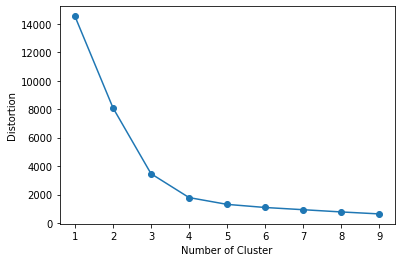

In [ ]:
# k - means를 진행해보자.
#일단 엘보우 포인트를 찾아보자. 
#3..4...?
distortions = []
param_init='random'
param_n_init=10
param_max_iter=300
for i in range(1, 10):
    km = KMeans(n_clusters=i, init=param_init, n_init=param_n_init, max_iter=param_max_iter, random_state=0)
    km.fit(data)
    distortions.append(km.inertia_)

plt.plot(range(1, 10), distortions, marker='o')
plt.xlabel('Number of Cluster')
plt.ylabel('Distortion')
plt.show()


In [ ]:
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]

In [ ]:
df['cluster'] = kmeans[3].predict(data)
df['principal_feature1'] = data[0]
df['principal_feature2'] = data[1]
df['cluster'].value_counts()
print(df['cluster'])

0       3
1       3
2       3
3       3
4       3
       ..
7262    0
7263    0
7264    0
7265    0
7266    0
Name: cluster, Length: 7267, dtype: int32


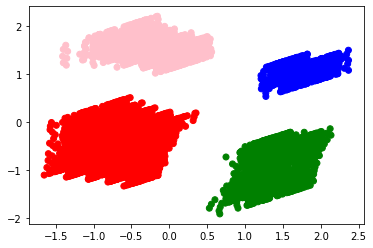

In [ ]:
fig, ax = plt.subplots()
colors = {0:'red', 1:'blue', 2:'green', 3:'pink'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["cluster"].apply(lambda x: colors[x]))
plt.show()

#생각해보면 당연할 수도 있다. 애초에 범주를 4가로 나누었으니 4개로 나오는 것이구나.
#근데 차원을 줄여도 비슷한 범주가 나온다는 것이 신기하다.

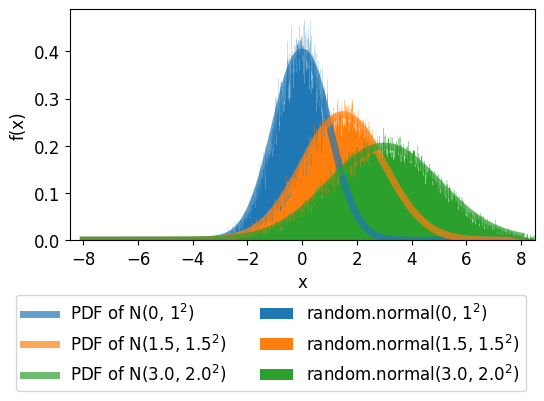

In [ ]:
#정규분포 그리는 법
#https://codetorial.net/articles/normal_distribution.html

import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

plt.style.use('default')
plt.rcParams['figure.figsize'] = (6, 3)
plt.rcParams['font.size'] = 12
plt.rcParams['lines.linewidth'] = 5

mu1, sigma1 = 0.0, 1.0
mu2, sigma2 = 1.5, 1.5
mu3, sigma3 = 3.0, 2.0

x = np.linspace(-8, 8, 1000)
y1 = (1 / np.sqrt(2 * np.pi * sigma1**2)) * np.exp(-(x-mu1)**2 / (2 * sigma1**2))
y2 = (1 / np.sqrt(2 * np.pi * sigma2**2)) * np.exp(-(x-mu2)**2 / (2 * sigma2**2))
y3 = (1 / np.sqrt(2 * np.pi * sigma3**2)) * np.exp(-(x-mu3)**2 / (2 * sigma3**2))

y4 = np.random.normal(mu1, sigma1, 50000)
y5 = np.random.normal(mu2, sigma2, 50000)
y6 = np.random.normal(mu3, sigma3, 50000)

plt.plot(x, y1, alpha=0.7, label=r'PDF of N(0, $1^2$)')
plt.plot(x, y2, alpha=0.7, label=r'PDF of N(1.5, $1.5^2$)')
plt.plot(x, y3, alpha=0.7, label=r'PDF of N(3.0, $2.0^2$)')

plt.hist(y4, bins=1000, density=True, histtype='stepfilled', label=r'random.normal(0, $1^2$)', color='C0')
plt.hist(y5, bins=1000, density=True, histtype='stepfilled', label=r'random.normal(1.5, $1.5^2$)', color='C1')
plt.hist(y6, bins=1000, density=True, histtype='stepfilled', label=r'random.normal(3.0, $2.0^2$)', color='C2')

plt.xlabel('x')
plt.ylabel('f(x)')
plt.xlim(-8.5, 8.5)
plt.legend(ncol=2, bbox_to_anchor=(1.0, -0.2))
plt.show()

#근데 변수를 뭘 써야하지.....???


#뭔가 망했다. 아무래도 변수를 잘못 쓴 것 같다.